### Loading Data

In [104]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
from ReliefF import ReliefF
import matplotlib.pyplot as plt

In [5]:
def combine_meta_data(df,meta_tuple,creative_tuple,option = 'both'):
  '''
  Meta data url is stored in a tuple:
  (url_meta_iso,url_meta_android,url_application)
  Creative url is stored in a tuple
  (url_creative,url_creative_tag,url_video)
  option - 'meta'/'creative'/'both', default both
  '''
  if (option == 'meta') | (option =='both'):

    meta_iso =  pd.read_csv(meta_tuple[0],sep='|',
      quotechar='"',header=None,error_bad_lines=False,warn_bad_lines=False)
    meta_android =  pd.read_csv(meta_tuple[1],sep='|',
      quotechar='"',header=None,error_bad_lines=False,warn_bad_lines=False)
    application = pd.read_csv(meta_tuple[2],header=None,sep='|',
      quotechar='"',error_bad_lines=False,warn_bad_lines=False)
    
    application.columns =['vungle_id','market_id','is_publisher','platform'] 
    meta_iso.columns=['market_id','title','created_at','last_updated_at',\
                      'version','size','developer','developer_website',\
                      'market_url','languages','content_rating','genre_ids',\
                      'genres','current_version_user_ratings',\
                      'n_current_version_user_ratings','user_rating',\
                      'n_user_ratings','price_currency_code','price_value',\
                      'min_os_version','supported_devices','screenshot_urls'
                     ]  
    meta_android.columns=['market_id','package_name','title','created_at',\
                      'last_updated_at','version','size','website',\
                      'developer','market_url','languages','content_rating',\
                      'primary_category','categories','user_rating',\
                      'n_user_ratings','price_currency_code','price_value',\
                      'n_min_downloads','n_max_downloads','has_in_app_purchases',\
                      'screenshot_urls','similar'
                     ]
    
    meta_iso.market_id=meta_iso.market_id.astype('string')
    application.market_id=application.market_id.astype('string')
    a = pd.merge(application,meta_iso,on='market_id',how='left')
    a = pd.merge(a,meta_android,on='market_id',how='left',suffixes=['','_android'])
    common= [i for i in a.columns if '_android' in i]
    common_iso = ['title','created_at','last_updated_at','version',\
                  'size','developer','market_url','languages',\
                  'content_rating','user_rating',\
                  'n_user_ratings','price_currency_code','price_value',\
                  'screenshot_urls']
    for i in range(len(common)):
      a[common_iso[i]].fillna(a[common[i]], inplace=True)
      del a[common[i]]
    
    
    columns = a.columns.values
    columns[0]='advertiser_app_store_id'
    a.columns=columns
    b = pd.merge(df,a,on='advertiser_app_store_id',how='left')
    columns = a.columns.values
    columns[0]='publisher_app_store_id'
    a.columns=columns
    b = pd.merge(b,a,on='publisher_app_store_id',how='left',suffixes=['','_publisher'])
    
    publisher_name = [i for i in b.columns if '_publisher' in i][1:]
    keep_col_name = ['_'.join(i.split('_')[0:-1]) for i in publisher_name] 
    b.loc[b.is_publisher=='t',keep_col_name] = np.nan
    for i in range(len(publisher_name)):
      b[keep_col_name[i]].fillna(b[publisher_name[i]], inplace=True)
      del b[publisher_name[i]]

  if (option == 'creative') | (option == 'both'): 
    if option =='creative':
      b = df

    # creative table
    df_creative = pd.read_table(creative_tuple[0],
                       sep='|',
                       quotechar='"',
                       warn_bad_lines=False,
                       error_bad_lines=False,header=None)
    df_creative.columns = ['creative_id','created_at','application_id','name','video_id',
                       'is_streaming','language','enforce_language_match','device_type_whitelist',
                      'delivery_frequency_cap','time_to_show_countdown','time_to_show_close_button',
                      'cloudux_template_id']
    # creative tag table
    df_creative_tag = pd.read_table(creative_tuple[1],
                       warn_bad_lines=False,
                       sep='|',
                       quotechar='"',
                       error_bad_lines=False,header=None)
    df_creative_tag.columns = ['creative_id','creative_tag']
    df_creative_tag = df_creative_tag.groupby('creative_id').creative_tag.apply(list).reset_index()
    # vidoe table
    '''
    df_video = pd.read_table(creative_tuple[2],
                       warn_bad_lines=False,
                       sep='|',
                       quotechar='"',
                       error_bad_lines=False,header=None)
    df_video.columns = ['video_id','size','id','width','height','duration'] 
    '''
    b= pd.merge(b, df_creative, how='left', on='creative_id',suffixes=['','_creative'])
    b = pd.merge(b, df_creative_tag, how='left', on='creative_id')

  return b

In [17]:
# df = pd.read_table('../data/000_sample1.gz',
#                        compression='gzip',
#                        sep='\t',
#                        quotechar='"',
#                        error_bad_lines=False)
df = pd.read_csv('tran_sample.csv')
df.head()

,Unnamed: 0,advertiser_app_store_id,country_code,city,campaign_id,creative_id,device_language,device_make,device_model,device_platform,...,n_vungle_installs,publisher_app_store_id,time_of_last_delivery_this_campaign,time_of_last_delivery_this_creative,time_of_last_delivery_any_installed_app,time_of_last_vungle_delivery,time_of_this_impression,timestamp_at_install,time_of_this_request,time_zone
0,1376899,587dd64b8bf3d1f61f0007ce,RU,NaN,58885746108ae4af4a000099,587df31ce4740a696d000173,ru,HUAWEI,HUAWEI LUA-L21,android,...,0.0,581765752717a0c91d000278,NaN,NaN,NaN,2017-01-27 15:14:27,2017-01-27 15:17:10,NaN,2017-01-27 15:15:38,Europe/Moscow
1,6581055,585215f054dbb89701000ba2,US,NaN,585247d492f308b72a00015a,5860bace91bcf915650001e9,en,samsung,SM-G930V,android,...,0.0,com.science.wishbone,2017-01-08 19:07:38,2017-01-08 19:07:38,NaN,2017-01-08 19:08:55,2017-01-29 18:46:01,2017-01-29 18:54:50,2017-01-29 18:44:12,America/Chicago
2,1634661,558bdb44bbed958866000191,CN,NaN,56e93be0eccafb7e3500006b,57a3384c68e2b9b42f000037,zh,iPhone7,1,iOS,...,0.0,56e27bcb4605bf8437000035,NaN,NaN,NaN,NaN,2017-01-27 17:45:12,NaN,2017-01-26 19:07:47,Asia/Shanghai
3,6499978,57bacc8f04d458e01d00012d,UA,NaN,57bdb834fc8b9e8f1c000021,57bdc9bfd699fdc74f000027,ru,Xiaomi,Redmi 3S,android,...,0.0,5661e00a8a3c8c661b000011,2017-01-29 12:40:10,NaN,NaN,2017-01-29 12:40:10,2017-01-29 18:02:53,NaN,2017-01-29 17:40:06,Europe/Kiev
4,1600943,com.rovio.ABstellapop,US,NaN,56cc9f30adffb0465b0002fd,5848d1d261edbada690000ab,en,LGE,LG-D851,android,...,0.0,587f3057e821bb914700038a,2017-01-26 13:33:30,NaN,NaN,2017-01-27 17:17:26,2017-01-27 17:24:37,NaN,2017-01-27 17:19:15,America/Chicago


In [18]:
df_merged = combine_meta_data(df,['../data/ios_apps_metadata000','../data/android_apps_metadata000','../data/applications000'],['../data/creatives000','../data/creative_tags000'],option = 'both')

In [21]:
df_merged.columns

Index([u'Unnamed: 0', u'advertiser_app_store_id', u'country_code', u'city',
       u'campaign_id', u'creative_id', u'device_language', u'device_make',
       u'device_model', u'device_platform', u'device_connection',
       u'device_os_version', u'device_screen_height', u'device_screen_width',
       u'device_volume', u'event_id', u'n_campaign_views',
       u'n_vungle_installs', u'publisher_app_store_id',
       u'time_of_last_delivery_this_campaign',
       u'time_of_last_delivery_this_creative',
       u'time_of_last_delivery_any_installed_app',
       u'time_of_last_vungle_delivery', u'time_of_this_impression',
       u'timestamp_at_install', u'time_of_this_request', u'time_zone',
       u'market_id', u'is_publisher', u'platform', u'title', u'created_at',
       u'last_updated_at', u'version', u'size', u'developer',
       u'developer_website', u'market_url', u'languages', u'content_rating',
       u'genre_ids', u'genres', u'current_version_user_ratings',
       u'n_current_version

In [188]:
df_merged['is_install'] = df_merged['timestamp_at_install'].notnull() * 1
df_merged['time_delta'] = pd.to_datetime(df_merged['time_of_this_impression'])-pd.to_datetime(df_merged['created_at'])
df_merged['time_delta_days'] = df_merged['time_delta'].dt.days

df_selected = df_merged.loc[:,['is_install','advertiser_app_store_id', 'publisher_app_store_id', 'country_code',
                               'campaign_id',
                               'time_delta_days','is_streaming','n_vungle_installs', 'n_campaign_views', 
                               'device_screen_height', 'device_screen_width', 'device_volume',
                               #new features from meta data
                               'content_rating', 'device_os_version'
                                ]]

In [189]:
df_selected.head()

,is_install,advertiser_app_store_id,publisher_app_store_id,country_code,campaign_id,time_delta_days,is_streaming,n_vungle_installs,n_campaign_views,device_screen_height,device_screen_width,device_volume,content_rating,device_os_version
0,0,587dd64b8bf3d1f61f0007ce,581765752717a0c91d000278,RU,58885746108ae4af4a000099,148.0,f,0.0,0,480.0,854.0,0.000000,Teen,5.1
1,1,585215f054dbb89701000ba2,com.science.wishbone,US,585247d492f308b72a00015a,81.0,f,0.0,1,2560.0,1440.0,0.200000,Everyone,6.0.1
2,0,558bdb44bbed958866000191,56e27bcb4605bf8437000035,CN,56e93be0eccafb7e3500006b,701.0,f,0.0,0,1125.0,2001.0,0.679965,12+,10.1.1
3,0,57bacc8f04d458e01d00012d,5661e00a8a3c8c661b000011,UA,57bdb834fc8b9e8f1c000021,208.0,f,0.0,0,1280.0,720.0,0.933333,Everyone,6.0.1
4,0,com.rovio.ABstellapop,587f3057e821bb914700038a,US,56cc9f30adffb0465b0002fd,688.0,f,0.0,0,2392.0,1440.0,0.000000,Everyone,6.0


### Clean the Data

In [197]:
df_selected1.isnull().sum()

is_install                 0
advertiser_app_store_id    0
publisher_app_store_id     0
country_code               0
campaign_id                0
time_delta_days            0
is_streaming               0
n_vungle_installs          0
n_campaign_views           0
device_screen_height       0
device_screen_width        0
device_volume              0
content_rating             0
device_os_version          0
dtype: int64

In [198]:
def fillna_avg(df, columns):
    """
    fill NA with mean
    """
    if isinstance(df, pd.DataFrame):
        for col in columns:
            df[col].fillna(df[col].mean(), inplace=True)
   
    return df

In [199]:
df_selected1 = fillna_avg(df_selected, ['time_delta_days'])
df_selected1 = df_selected1.dropna(axis=0, how='any') 

In [200]:
df_selected1["is_streaming"] = df_selected1["is_streaming"].astype('category')
df_selected1["is_streaming"] = df_selected1.is_streaming.cat.rename_categories([1,2])
df_selected1["is_streaming"] = df_selected1["is_streaming"].astype('category')

In [218]:
df_selected1["content_rating"] = df_selected1["content_rating"].astype('category')
df_selected1["content_rating"] = df_selected1.content_rating.cat.rename_categories([i+1 for i in range(8)])
df_selected1["content_rating"] = df_selected1["content_rating"].astype('category')

In [219]:
print df_selected1.shape
print df_selected1.head()

(6774, 14)
   is_install   advertiser_app_store_id    publisher_app_store_id  \
0           0  587dd64b8bf3d1f61f0007ce  581765752717a0c91d000278   
1           1  585215f054dbb89701000ba2      com.science.wishbone   
2           0  558bdb44bbed958866000191  56e27bcb4605bf8437000035   
3           0  57bacc8f04d458e01d00012d  5661e00a8a3c8c661b000011   
4           0     com.rovio.ABstellapop  587f3057e821bb914700038a   

  country_code               campaign_id  time_delta_days is_streaming  \
0           RU  58885746108ae4af4a000099            148.0            1   
1           US  585247d492f308b72a00015a             81.0            1   
2           CN  56e93be0eccafb7e3500006b            701.0            1   
3           UA  57bdb834fc8b9e8f1c000021            208.0            1   
4           US  56cc9f30adffb0465b0002fd            688.0            1   

   n_vungle_installs  n_campaign_views  device_screen_height  \
0                0.0                 0                 480.0   
1

In [220]:
df_selected1.dtypes

is_install                    int64
advertiser_app_store_id      object
publisher_app_store_id       object
country_code                 object
campaign_id                  object
time_delta_days             float64
is_streaming               category
n_vungle_installs           float64
n_campaign_views              int64
device_screen_height        float64
device_screen_width         float64
device_volume               float64
content_rating             category
device_os_version            object
dtype: object

### RELIEFF Feature Selection

In [221]:
X,y = df_selected1.loc[:,['time_delta_days','is_streaming','n_vungle_installs', 'n_campaign_views', 
                               'device_screen_height', 'device_screen_width', 'device_volume','content_rating']], df_selected1['is_install']

# fs = ReliefF(n_neighbors=20, n_features_to_keep=5)
# fs.fit(X=X,y=y)
# X_train = fs.fit_transform(X, y)
# X_test_subset = fs.transform(X_test)
# print(X_test.shape, X_test_subset.shape)

In [222]:
X.head()

,time_delta_days,is_streaming,n_vungle_installs,n_campaign_views,device_screen_height,device_screen_width,device_volume,content_rating
0,148.0,1,0.0,0,480.0,854.0,0.000000,8
1,81.0,1,0.0,1,2560.0,1440.0,0.200000,5
2,701.0,1,0.0,0,1125.0,2001.0,0.679965,1
3,208.0,1,0.0,0,1280.0,720.0,0.933333,5
4,688.0,1,0.0,0,2392.0,1440.0,0.000000,5


### Random Forecast

In [223]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=5, random_state=0)
clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [224]:
selected_features = ['time_delta_days','is_streaming','n_vungle_installs', 'n_campaign_views', 
                               'device_screen_height', 'device_screen_width', 'device_volume','content_rating','device_os_version']
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis=0)
features = X.columns[indices]

In [225]:
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, selected_features[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature time_delta_days (0.355745)
2. feature device_volume (0.203606)
3. feature device_screen_height (0.127268)
4. feature device_screen_width (0.112461)
5. feature n_campaign_views (0.075096)
6. feature content_rating (0.071923)
7. feature n_vungle_installs (0.053873)
8. feature is_streaming (0.000028)


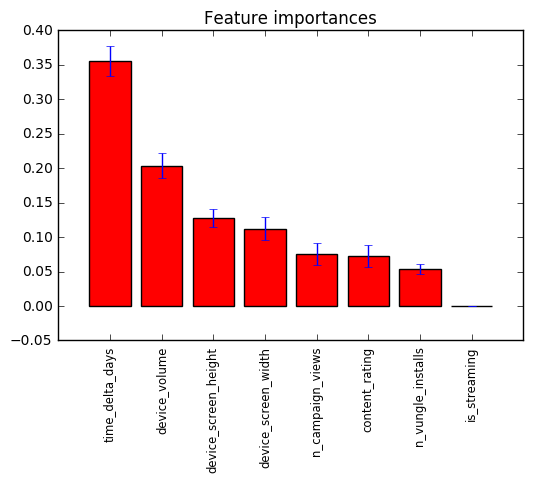

In [229]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), [selected_features[indices[f]] for f in range(X.shape[1])], size='small',rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()